In [1]:
%matplotlib inline

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [15]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import decomposition, manifold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [16]:
colors = np.array([
    [166,206,227],
    [31,120,180],
    [178,223,138],
    [51,160,44],
    [251,154,153],
    [227,26,28],
    [253,191,111],
    [255,127,0],
    [202,178,214],
    [106,61,154],
]) / 255.0

colors_init = np.hstack((colors, np.zeros((colors.shape[0], 1))))
colors_full = np.hstack((colors, np.ones((colors.shape[0], 1))))

cmaps = [matplotlib.colors.LinearSegmentedColormap.from_list("S0", [colors_init[i], colors_full[i]])
         for i in range(colors.shape[0])]

In [4]:
import torch.utils.data

class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None, batch_sampler=None,
                 drop_last=False):
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [5]:
MNIST_MEAN, MNIST_STD = 0.1307, 0.3081
mnist_train_dataset = datasets.MNIST('../data', train=True, download=True)
mnist_test_dataset = datasets.MNIST('../data', train=False, download=True)
mnist_train_tensors = (
    (mnist_train_dataset.train_data[:50000].float() / 255.0 - MNIST_MEAN) / MNIST_STD,
    mnist_train_dataset.train_labels[:50000])
mnist_valid_tensors = (
    (mnist_train_dataset.train_data[50000:].float() / 255.0 - MNIST_MEAN) / MNIST_STD,
    mnist_train_dataset.train_labels[50000:])
mnist_test_tensors = (
    (mnist_test_dataset.test_data.float() / 255.0 - MNIST_MEAN) / MNIST_STD,
    mnist_test_dataset.test_labels)

In [6]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target % 5)  # XXX MOD
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [7]:
#C1S, C2S, F1S = 20, 50, 500
C1S, C2S, F1S = 20, 50, 200

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, C1S, 5, 1)
        self.conv2 = nn.Conv2d(C1S, C2S, 5, 1)
        self.fc1 = nn.Linear(4*4*C2S, F1S)
        self.fc2 = nn.Linear(F1S, 10)

    def forward(self, x, probe_pts=None):
        if probe_pts is None:
            probe_pts = {}
        if probe_pts:
            def save_probe(name, val):
                if name in probe_pts:
                    probe_pts[name] = val
        else:
            def save_probe(name, val):
                pass
        if len(x.shape) == 3:
            x = x[:, None, :, :]
        x = F.relu(self.conv1(x))
        save_probe('cr1', x)
        x = F.max_pool2d(x, 2, 2)
        save_probe('p1', x)
        x = F.relu(self.conv2(x))
        save_probe('cr2', x)
        x = F.max_pool2d(x, 2, 2)
        save_probe('p2', x)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        save_probe('fr1', x)
        x = self.fc2(x)
        save_probe('f2', x)
        return F.log_softmax(x, dim=1)

In [8]:
class args:
    seed = 1
    batch_size = 64
    test_batch_size = 1000
    epochs = 20

    lr = 0.01
    momentum = 0.5

    log_interval = 100
    use_cuda = True
    
    save_model = True

In [9]:
torch.manual_seed(args.seed)

device = torch.device("cuda" if args.use_cuda else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize((0.1307,), (0.3081,))
#                    ])),
#     batch_size=args.test_batch_size, shuffle=False, **kwargs)

train_loader = InMemDataLoader(
    mnist_train_tensors, batch_size=args.batch_size, shuffle=True).to(device)
test_loader = InMemDataLoader(
    mnist_test_tensors, batch_size=args.test_batch_size, shuffle=False).to(device)


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(),"mnist_cnn.pt")

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.278582
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.463680
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.280772
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.274650
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.158586
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.112882
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.150828
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.213766

Test set: Average loss: 6.1704, Accuracy: 5037/10000 (50%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.056162
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.097626
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.068921
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.141797
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.029197
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.134383
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.186624
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.061186

Test set: Average loss: 6.4136, Accuracy: 5062/10000 (51%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.116911
Train Epoch: 3 [6400/50000 (13%)]	Loss: 0.096


Test set: Average loss: 10.1836, Accuracy: 5111/10000 (51%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.005200
Train Epoch: 19 [6400/50000 (13%)]	Loss: 0.002144
Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.000563
Train Epoch: 19 [19200/50000 (38%)]	Loss: 0.000591
Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.000537
Train Epoch: 19 [32000/50000 (64%)]	Loss: 0.007057
Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.035662
Train Epoch: 19 [44800/50000 (90%)]	Loss: 0.017205

Test set: Average loss: 10.0643, Accuracy: 5106/10000 (51%)

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.000691
Train Epoch: 20 [6400/50000 (13%)]	Loss: 0.000754
Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.003275
Train Epoch: 20 [19200/50000 (38%)]	Loss: 0.006445
Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.026374
Train Epoch: 20 [32000/50000 (64%)]	Loss: 0.001217
Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.007329
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.001781

Test set: Average loss: 10.5984, Accuracy: 5112/10000 (51%)



In [10]:
list(model.named_modules())

[('', Net(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )),
 ('conv1', Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))),
 ('conv2', Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))),
 ('fc1', Linear(in_features=800, out_features=200, bias=True)),
 ('fc2', Linear(in_features=200, out_features=10, bias=True))]

In [18]:
train_x, train_y = train_loader.dataset.tensors
test_x, test_y = test_loader.dataset.tensors
res_dict = {'fr1': True}
with torch.no_grad():
    _ = model.forward(train_x[:10000], probe_pts=res_dict).cpu().numpy()
    F_train = res_dict['fr1']

(-24.58178857680778, 26.909329059141918)

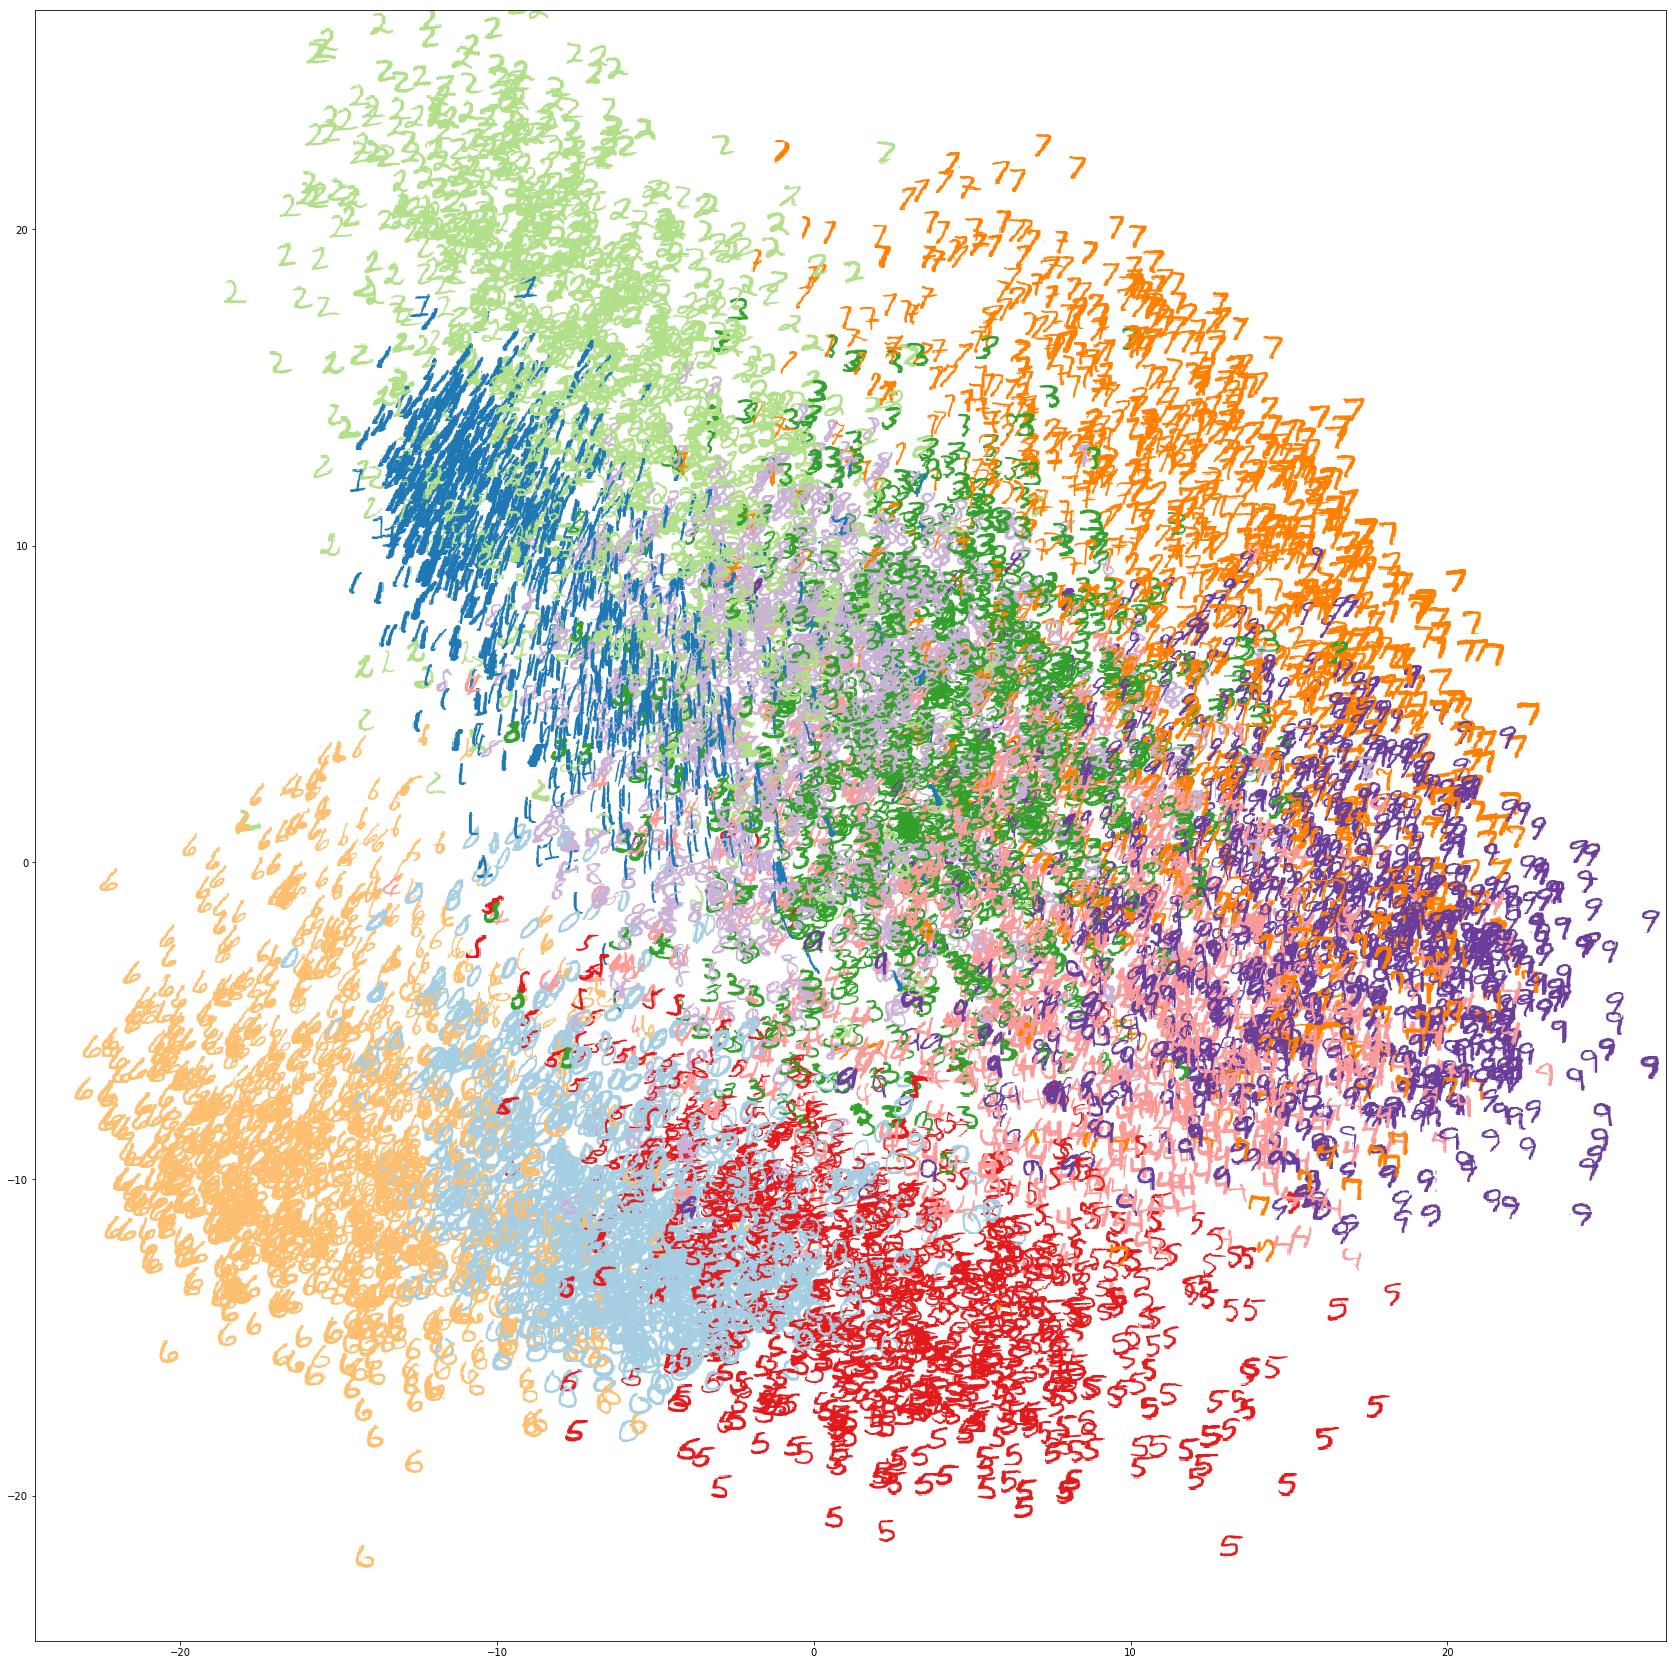

In [22]:
pca = decomposition.PCA(2)
F_train_2d_pca = pca.fit_transform(F_train)
plt.figure(figsize=(30, 30))
ax = plt.gca()
for i in range(10000):
    ax.imshow(train_x[i], cmap=cmaps[train_y[i]],
              extent=[F_train_2d_pca[i, 0], F_train_2d_pca[i, 0]+1, F_train_2d_pca[i, 1], F_train_2d_pca[i, 1]+1])
plt.xlim(F_train_2d_pca[:,0].min() - 1, F_train_2d_pca[:,0].max() + 1)
plt.ylim(F_train_2d_pca[:,0].min() - 1, F_train_2d_pca[:,0].max() + 1)

In [ ]:
tsne = manifold.TSNE()
F_train_2d = tsne.fit_transform(F_train)

(-84.3030776977539, 86.59678649902344)

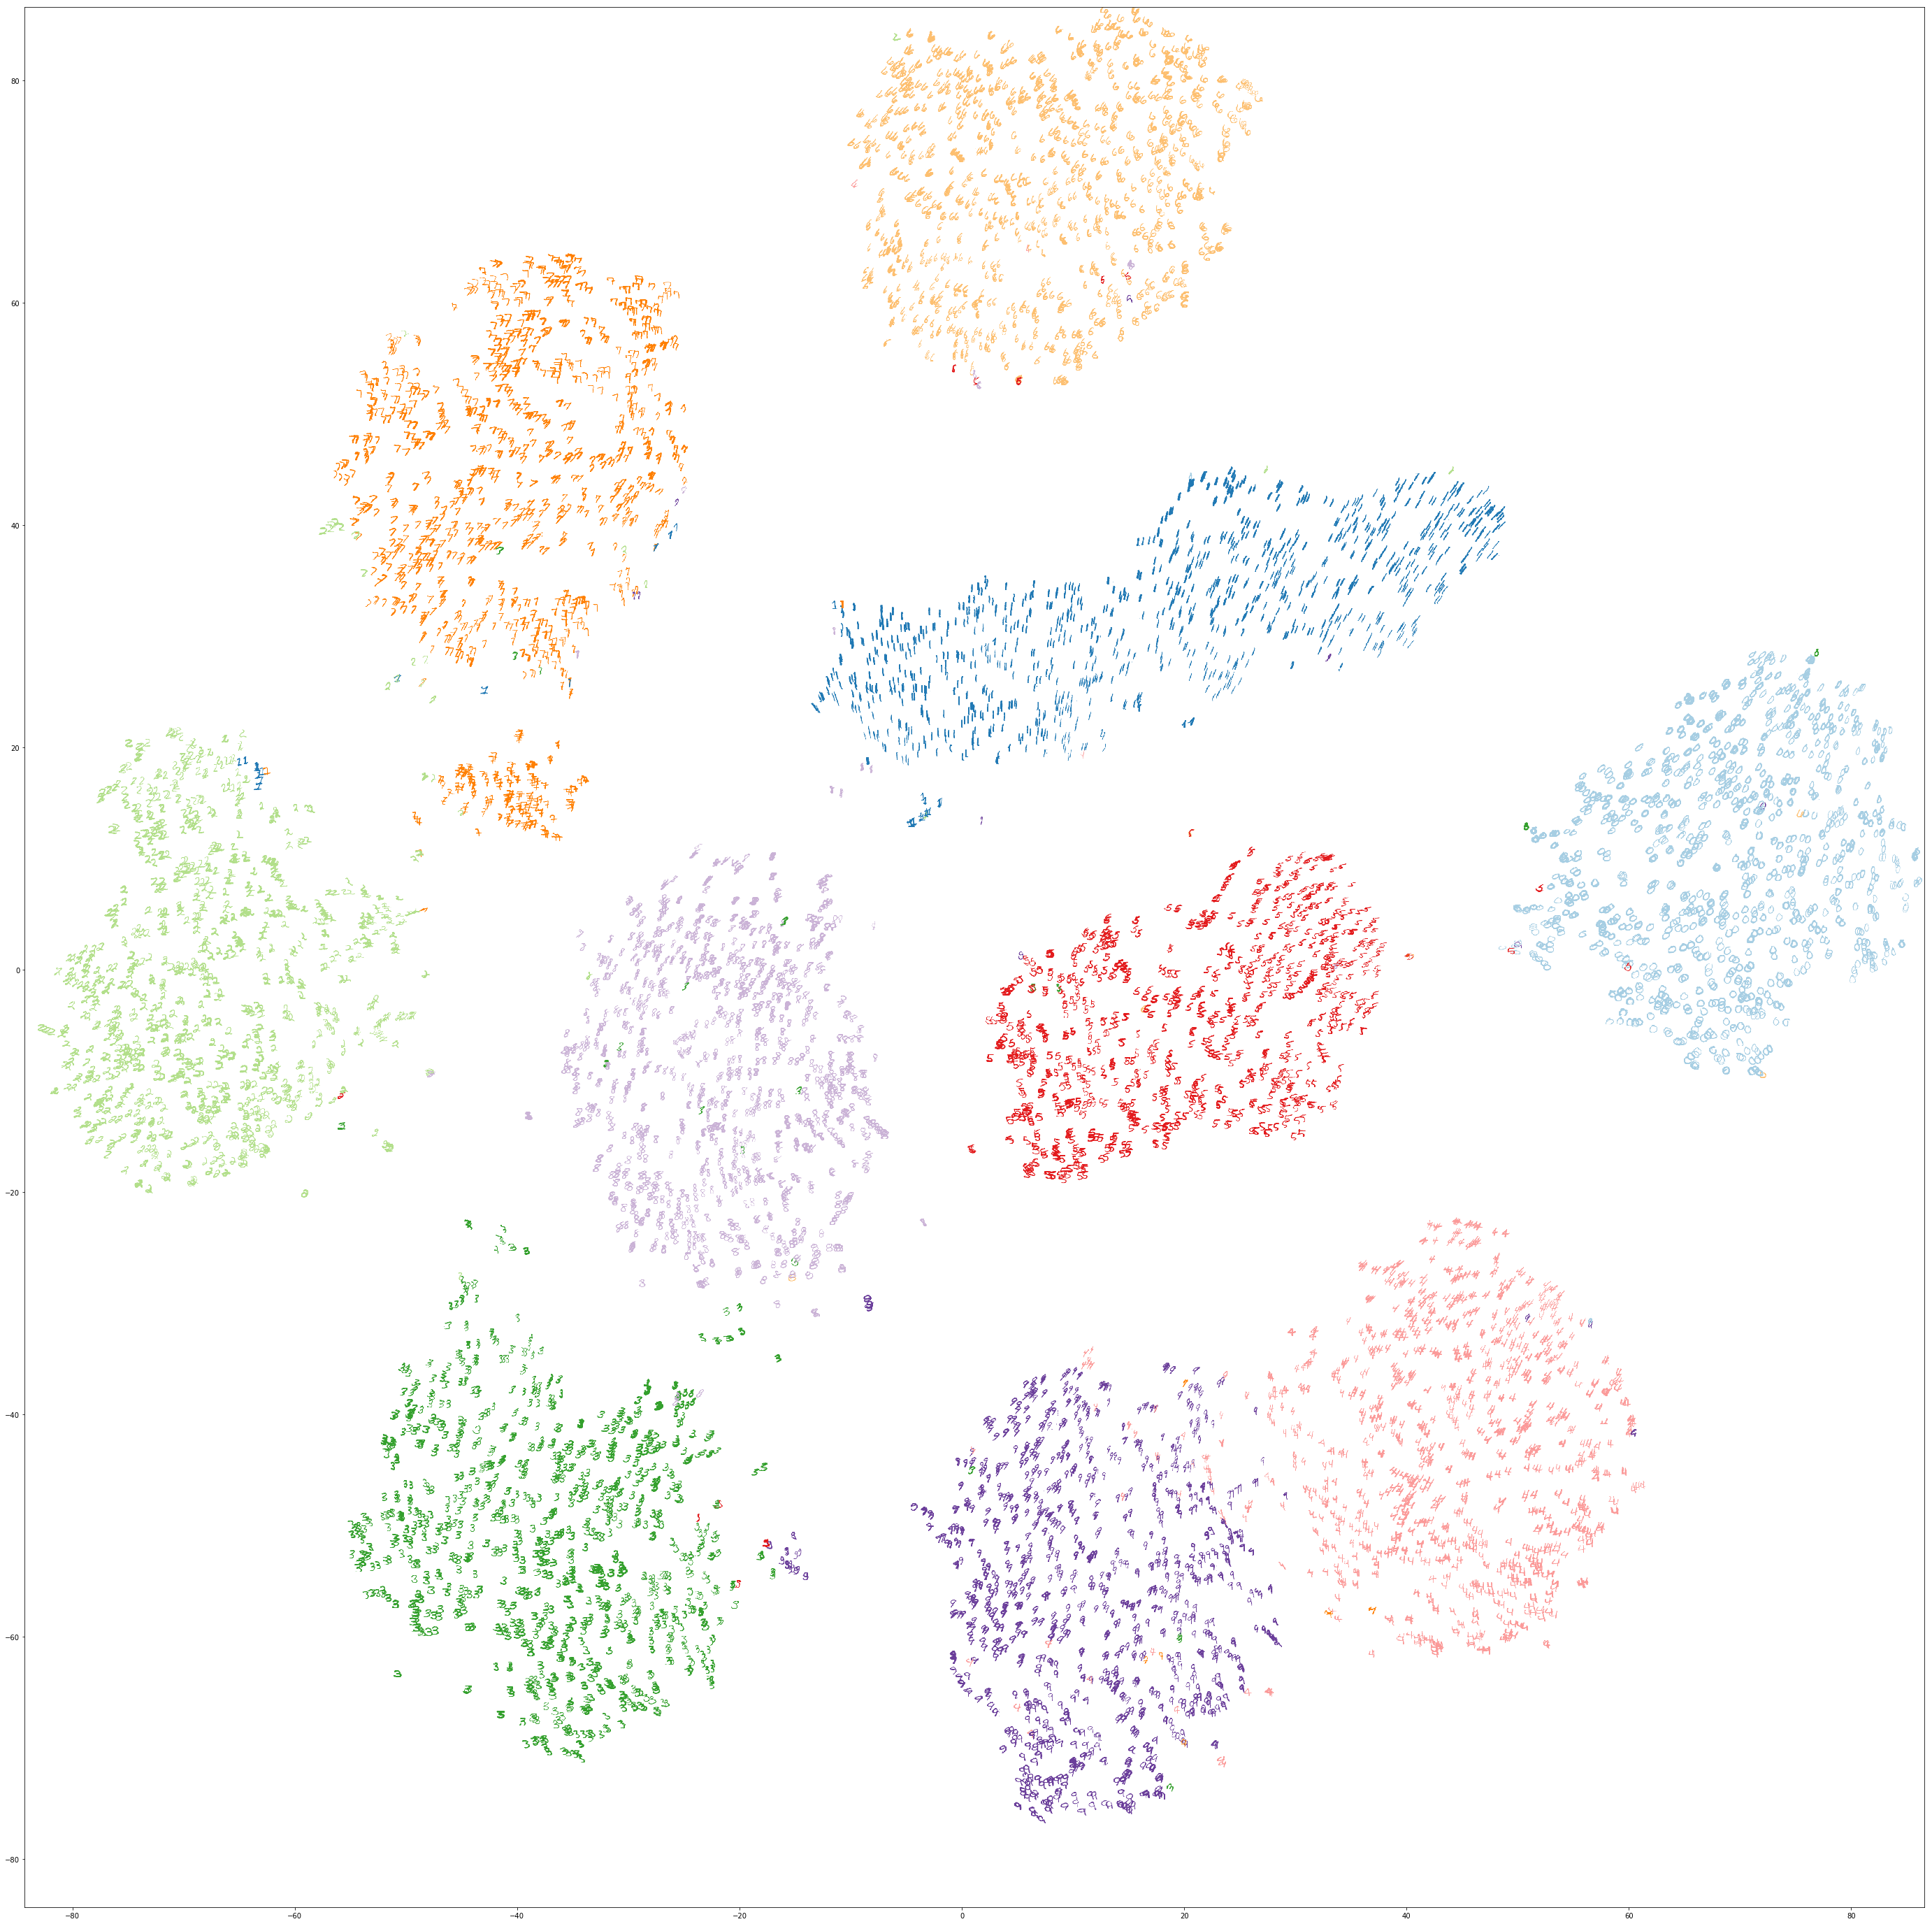

In [23]:
plt.figure(figsize=(50, 50))
ax = plt.gca()
for i in range(10000):
    ax.imshow(train_x[i], cmap=cmaps[train_y[i]],
              extent=[F_train_2d[i, 0], F_train_2d[i, 0]+1, F_train_2d[i, 1], F_train_2d[i, 1]+1])
plt.xlim(F_train_2d[:,0].min() - 1, F_train_2d[:,0].max() + 1)
plt.ylim(F_train_2d[:,0].min() - 1, F_train_2d[:,0].max() + 1)